In [1]:
import numpy as np 
import os
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.models import *
from keras.layers import *
from keras import initializers
from keras import backend as K
import tensorflow as tf
import numpy as np 
import os
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import segmentation_models as sm
from keras.losses import categorical_crossentropy

import tensorflow as tf

import sys
    
sys.path.insert(1,r"C:\Users\adame\Desktop\Inzynierka")

Segmentation Models: using `keras` framework.


In [2]:
from generator import image_load_generator_x,image_load_generator_mask,image_load_generator_mask_binary,image_load_generator_mask_nocat


In [3]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="Model_iou_cat_dice", entity="adamsoja")




C:\anaconda3\envs\machine\lib\site-packages\IPython\html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "
wandb: Currently logged in as: adamsoja. Use `wandb login --relogin` to force relogin


In [4]:
batch_size = 6
train_X = image_load_generator_x('../brains/train',batch_size)
train_mask_gen = image_load_generator_mask('../brains/train',batch_size)

val_X = image_load_generator_x('../brains/valid',batch_size)
val_mask_gen = image_load_generator_mask('../brains/valid',batch_size)
import os

steps_train = len(os.listdir('../brains/train/mask')) // batch_size
steps_val = len(os.listdir('../brains/valid/mask')) // batch_size



FileNotFoundError: [WinError 3] System nie może odnaleźć określonej ścieżki: '../brains/train/mask'

In [ ]:
train_datagen = zip(train_X,train_mask_gen)
val_datagen = zip(val_X,val_mask_gen)

In [ ]:
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25,0.25,0.25,0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (3 * focal_loss)
metrics = [sm.metrics.IOUScore(), sm.metrics.FScore()]


In [7]:
def dice_coef(y_true, y_pred, smooth=1.0):
    ''' Dice Coefficient
    Args:
        y_true (np.array): Ground Truth Heatmap (Label)
        y_pred (np.array): Prediction Heatmap
    '''

    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss


def dice_coef_loss(y_true, y_pred):
    ''' Dice Coefficient Loss
    Args:
        y_true (np.array): Ground Truth Heatmap (Label)
        y_pred (np.array): Prediction Heatmap
    '''
    return 1-dice_coef(y_true, y_pred)


metrics = [tf.keras.metrics.MeanIoU(num_classes=4),'accuracy',dice_coef]

In [ ]:

def multi_unet_model(n_classes=4, IMG_HEIGHT=240, IMG_WIDTH=240, IMG_CHANNELS=1):
    #Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.6)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.1)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.6)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])

    return model


import keras
opt = keras.optimizers.Adam(learning_rate=0.0001)

model = multi_unet_model(n_classes=4, IMG_HEIGHT=240, IMG_WIDTH=240, IMG_CHANNELS=1)



model.compile(optimizer=opt, loss=total_loss, metrics=[metrics])

#model.summary()


In [ ]:
model.fit(train_datagen,
                    steps_per_epoch = steps_train,
                    verbose=1,
                    epochs=15, 
                    validation_data=val_datagen, 
                    validation_steps = steps_val,
                    shuffle=False,
                    callbacks=[WandbCallback()],
                   )
                    
    

In [ ]:
model.save('../models/iou.h5')

In [ ]:
def make_accuracy_plot(history):
    """
    Accuracy plot of model 
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set()
    acc, val_acc = history.history['dice_coef'], history.history['val_dice_coef']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 8))
    plt.plot(epochs, acc, label='Training dice', marker='o')
    plt.plot(epochs, val_acc, label='Validation dice', marker='o')
    plt.legend()
    plt.title('Dokładność trenowania i walidacji')
    plt.xlabel('Epoki')
    plt.ylabel('Dice')
    plt.show()

def make_loss_plot(history):
    """
    Loss plot of model
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set()
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(10, 8))
    plt.plot(epochs, loss, label='Training loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation loss', marker='o')
    plt.legend()
    plt.title('Strata trenowania i walidacji')
    plt.xlabel('Epoki')
    plt.ylabel('Strata')
    plt.show()


In [ ]:
make_accuracy_plot(history)

In [ ]:
make_loss_plot(history)

In [1]:
import sys
    
sys.path.insert(1,r"C:\Users\adame\Desktop\Inzynierka")

In [2]:
import tensorflow as  tf
import os

In [3]:
import numpy as np 
from generator import image_load_generator_x,image_load_generator_mask,image_load_generator_mask_nocat
import keras
import matplotlib.pyplot as plt
import random
import tensorflow as  tf
path = '../brains/test'
batch_size = 20
files = os.listdir(f'{path}/brain')

test_generator = image_load_generator_x(path,files,batch_size)
mask_generator =image_load_generator_mask(path,files,batch_size)

model = tf.keras.models.load_model('../models/dice_160x160_4channels.h5',compile=False)

1/1 [==============================] - 9s 9s/step


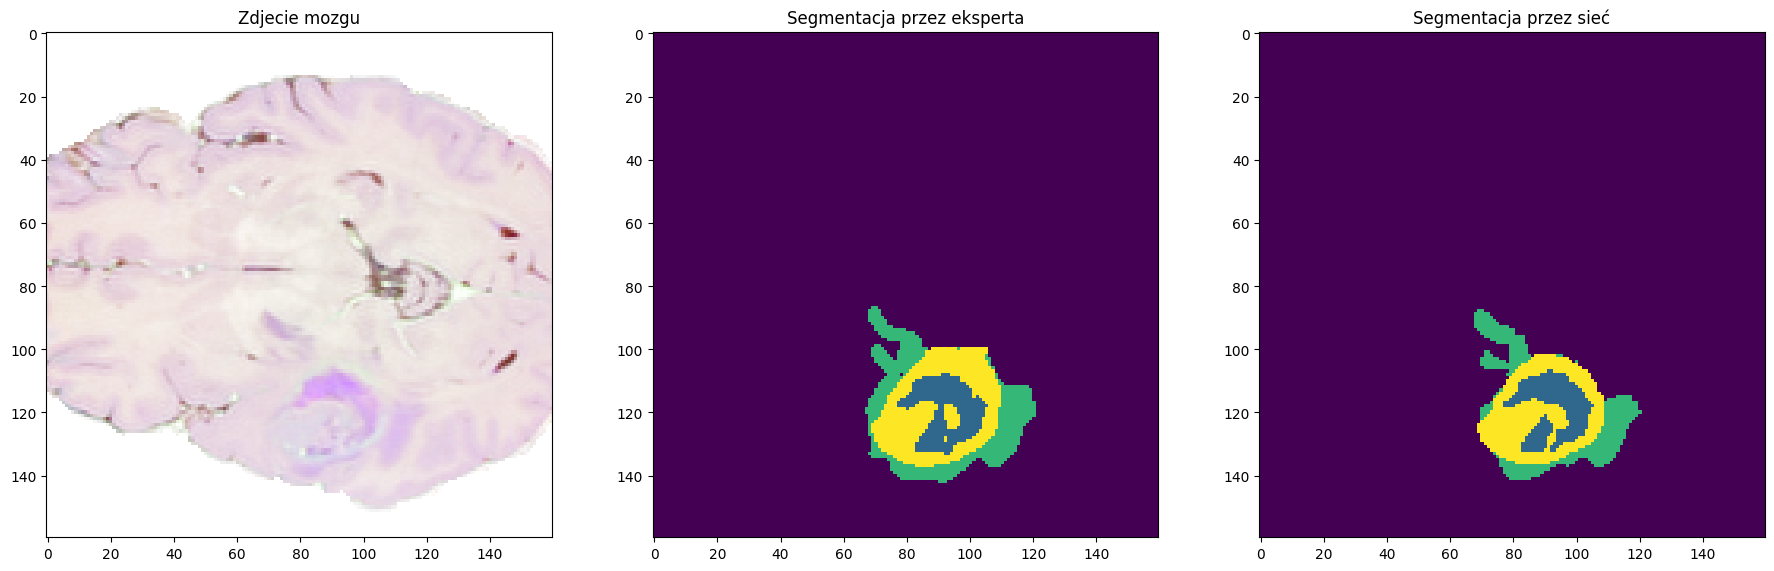

In [4]:
X_test = next(test_generator)
Y_test = next(mask_generator)

y_pred = model.predict(X_test)

predicted_img=np.argmax(y_pred,axis=3)
number = random.randint(0,9)

brain = X_test[number]
plt.figure(figsize=(30, 20))
plt.subplot(241)
plt.title('Zdjecie mozgu')
plt.imshow(brain)
plt.subplot(242)
plt.title('Segmentacja przez eksperta')
plt.imshow(np.argmax(Y_test[number],axis=-1))
plt.subplot(243)
plt.title('Segmentacja przez sieć')
plt.imshow(predicted_img[number])

plt.show()

In [6]:
from keras.metrics import MeanIoU
n_classes = 4
masks = np.argmax(Y_test,axis=3)
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(masks,predicted_img)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.8229202


In [7]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for background is: ", class1_IoU)
print("IoU for label 1 is: ", class2_IoU)
print("IoU for label 2 is: ", class3_IoU)
print("IoU for label 4 is: ", class4_IoU)

IoU for background is:  0.990147
IoU for label 1 is:  0.7863927
IoU for label 2 is:  0.68191326
IoU for label 4 is:  0.833228


In [ ]:
table = wandb.Table(columns=['ID', 'Image'])

train_X2 = image_load_generator_x('../brains/train',batch_size)
train_mask_gen2 = image_load_generator_mask_nocat('../brains/train',batch_size)


class_labels = {
  0: "background",
  1: "necrotic and non-enhancing tumor",
  2: "edema",
    4: 'enhancing tumor'
}


images = next(train_X2)
labels = next(train_mask_gen2)

for i in range(batch_size):
    img = images[i]
    
    wandb.log(
  {"my_image_key" : wandb.Image(img[:,:,2], masks={
    "predictions" : {
        "mask_data" : labels[i],
        "class_labels" : class_labels
    },
    "ground_truth" : {
        "mask_data" : labels[i],
        "class_labels" : class_labels
    }
})})



In [ ]:
                flipped = tf.image.flip_left_right(X_train)
                x_train.append(flipped)
                
                rotated = tf.image.rot90(X_train)
                x_train.append(rotated)
                
                rotated2 = tf.image.rot90(rotated)
                x_train.append(rotated2)
                
                
                flipped = tf.image.flip_left_right(X_train)
                x_train.append(flipped)
                
                rotated = tf.image.rot90(X_train)
                x_train.append(rotated)
                
                rotated2 = tf.image.rot90(rotated)
                x_train.append(rotated2)
                

In [1]:
import numpy as np
np.ones(4)

array([1., 1., 1., 1.])